In [15]:
# imports
import numpy as np
import matplotlib.pyplot as plt

In [17]:
# Given data for main sequence lifetime
M   = np.array([0.5, 1.0, 1.5, 2.0, 3.0, 5.0, 10.0, 20.0])
tau = np.array([56000, 10000, 3000, 1300, 400, 100, 20, 5])

In [19]:
# function definitions

# ============================================
# Linear interpolation function
# ============================================
def linear_interpolation(x_data, y_data, x_new):
    """
    Perform linear interpolation.
    
    Parameters:
        x_data (np.array): Known x-values (must be sorted).
        y_data (np.array): Known y-values corresponding to x_data.
        x_new (np.array): New x-values at which to interpolate.

    Returns:
        y_new (np.array): Interpolated y-values.
    """
    y_new = np.zeros_like(x_new)
    for idx, x_val in enumerate(x_new):
        for i in range(len(x_data) - 1):
            if x_data[i] <= x_val <= x_data[i+1]:
                y_new[idx] = y_data[i] + (x_val - x_data[i]) * (y_data[i+1] - y_data[i]) / (x_data[i+1] - x_data[i])
                break
            else:
                # Extrapolation: use the nearest interval
                if x_val < x_data[0]:
                    i = 0
                else:
                    i = len(x_data) - 2
                y_new[idx] = y_data[i] + (x_val - x_data[i]) * (y_data[i+1] - y_data[i]) / (x_data[i+1] - x_data[i])
    return y_new


# ============================================
# Cubic spline interpolation coefficients
# ============================================
def cubic_spline_coefficients(x, a):
    """
    Compute the coefficients of the natural cubic spline interpolation.

    Parameters:
        x (np.array): Known x-values (sorted).
        a (np.array): Known y-values corresponding to x.

    Returns:
        (tuple): Coefficients (a_j, b_j, c_j, d_j) for each interval.
    """
    n = len(x) - 1
    h = np.zeros(n)
    alpha = np.zeros(n)

    # Step 1: Compute h_i
    for i in range(n):
        h[i] = x[i+1] - x[i]

    # Step 2: Compute alpha_i
    for i in range(1, n):
        alpha[i] = (3 / h[i]) * (a[i+1] - a[i]) - (3 / h[i-1]) * (a[i] - a[i-1])
        
    # Step 3: Initialize l, mu, z arrays
    l = np.zeros(n+1)
    mu = np.zeros(n+1)
    z = np.zeros(n+1)

    l[0] = 1
    mu[0] = 0
    z[0] = 0

    # Step 4: Solve tridiagonal system
    for i in range(1, n):
        l[i] = 2 * (x[i+1] - x[i-1]) - h[i-1] * mu[i-1]
        mu[i] = h[i] / l[i]
        z[i] = (alpha[i] - h[i-1] * z[i-1]) / l[i]

    # Step 5: Set boundary conditions
    l[n] = 1 
    z[n] = 0 

    # Step 6: Back substitution
    c = np.zeros(n+1)
    b = np.zeros(n)
    d = np.zeros(n)

    mu[n] = 0
    for j in range(n-1, -1, -1):
        c[j] = z[j] - mu[j] * c[j+1]
        b[j] = (a[j+1] - a[j]) / h[j] - h[j] * (c[j+1] + 2 * c[j]) / 3
        d[j] = (c[j+1] - c[j]) / (3 * h[j])


    return a[:-1], b, c[:-1], d

# ============================================
# Evaluate cubic spline at new points
# ============================================
def evaluate_cubic_spline(x_data, coeffs, x_eval):
    """
    Evaluate the cubic spline at new x-values.

    Parameters:
        x_data (np.array): Known x-values (sorted).
        coeffs (tuple): Coefficients (a, b, c, d) for the spline.
        x_eval (np.array): New x-values to evaluate the spline.

    Returns:
        y_eval (np.array): Interpolated y-values at x_eval.
    """
    a, b, c, d = coeffs
    y_eval = np.zeros_like(x_eval)
    for idx, x_val in enumerate(x_eval):
        for i in range(len(x_data) - 1):
            if x_data[i] <= x_val <= x_data[i+1]:
                dx = x_val - x_data[i]
                y_eval[idx] = a[i] + b[i] * dx + c[i] * dx**2 + d[i] * dx**3
                break
            else:
                # Extrapolation: use the nearest interval
                if x_val < x_data[0]:
                    i = 0
                else:
                    i = len(x_data) - 2
                dx = x_val - x_data[i]
                y_eval[idx] = a[i] + b[i] * dx + c[i] * dx**2 + d[i] * dx**3
    return y_eval


In [21]:
# verification

# ============================================
# Simple known data set
# ============================================
x_test = np.array([0.0, 1.0, 2.0])
a_test = np.array([0.0, 1.0, 0.0])

# ============================================
# Compute coefficients
# ============================================
a_coeff, b_coeff, c_coeff, d_coeff = cubic_spline_coefficients(x_test, a_test)

print("Computed coefficients:")
for i in range(len(a_coeff)):
    print(f"Interval {i}: a = {a_coeff[i]:.4f}, b = {b_coeff[i]:.4f}, c = {c_coeff[i]:.4f}, d = {d_coeff[i]:.4f}")

# Expected:
expected = np.array([
    [0.0, 1.5, 0.0, -0.5],  # [a0, b0, c0, d0]
    [1.0, 0.0, -1.5, 0.5]   # [a1, b1, c1, d1]
])

# ============================================
# Verify correctness
# ============================================
print("\nComparison with expected values:")
for i in range(len(expected)):
    print(f"Interval {i}: ")
    print(f"  a: computed = {a_coeff[i]:.4f}, expected = {expected[i,0]:.4f}")
    print(f"  b: computed = {b_coeff[i]:.4f}, expected = {expected[i,1]:.4f}")
    print(f"  c: computed = {c_coeff[i]:.4f}, expected = {expected[i,2]:.4f}")
    print(f"  d: computed = {d_coeff[i]:.4f}, expected = {expected[i,3]:.4f}")


Computed coefficients:
Interval 0: a = 0.0000, b = 1.5000, c = 0.0000, d = -0.5000
Interval 1: a = 1.0000, b = 0.0000, c = -1.5000, d = 0.5000

Comparison with expected values:
Interval 0: 
  a: computed = 0.0000, expected = 0.0000
  b: computed = 1.5000, expected = 1.5000
  c: computed = 0.0000, expected = 0.0000
  d: computed = -0.5000, expected = -0.5000
Interval 1: 
  a: computed = 1.0000, expected = 1.0000
  b: computed = 0.0000, expected = 0.0000
  c: computed = -1.5000, expected = -1.5000
  d: computed = 0.5000, expected = 0.5000


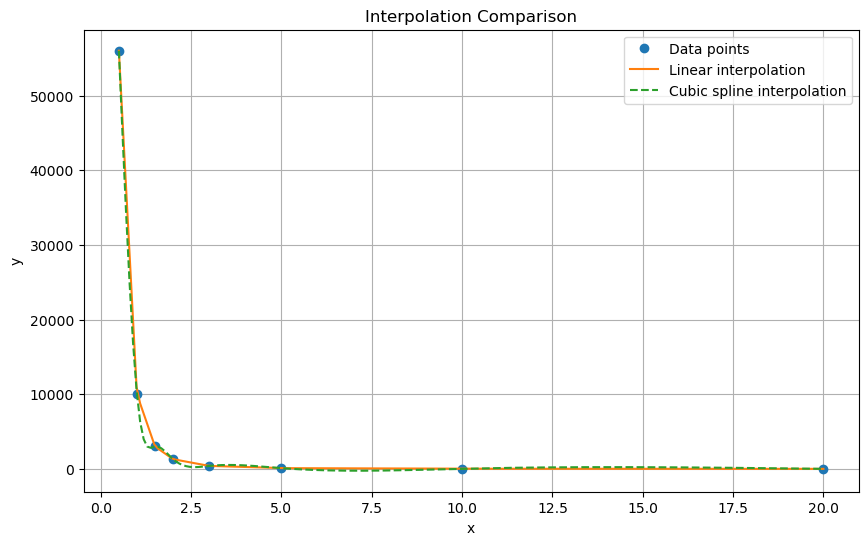

In [23]:
# ============================================
# Example usage
# ============================================
x_new = np.linspace(0.5, 20.0, 200)

# Linear interpolation
y_linear = linear_interpolation(M, tau, x_new)

# Cubic spline interpolation
coeffs = cubic_spline_coefficients(M, tau)
y_spline = evaluate_cubic_spline(M, coeffs, x_new)

plt.figure(figsize=(10, 6))
plt.plot(M, tau, 'o', label='Data points')
plt.plot(x_new, y_linear, '-', label='Linear interpolation')
plt.plot(x_new, y_spline, '--', label='Cubic spline interpolation')
plt.xlabel('x')
plt.ylabel('y')
plt.title('Interpolation Comparison')
plt.legend()
plt.grid(True)
plt.show()


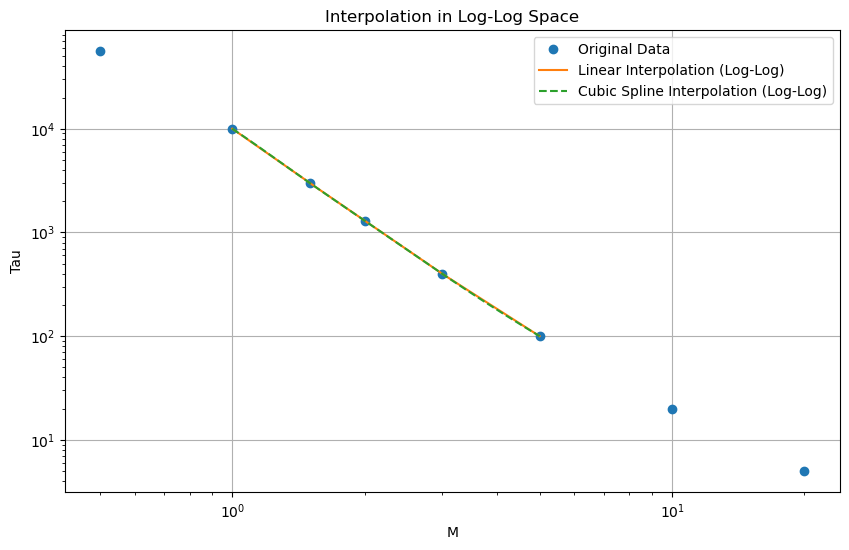

In [25]:
# ============================================
# Prepare Log-Log data
# ============================================
logM = np.log10(M)
logTau = np.log10(tau)

logM_new = np.linspace(np.log10(1.0), np.log10(5.0), 200)

# Interpolate in log-log space
logTau_linear = linear_interpolation(logM, logTau, logM_new)
logTau_spline = evaluate_cubic_spline(logM, cubic_spline_coefficients(logM, logTau), logM_new)

# Back-transform to original space
M_new = 10**logM_new
tau_linear = 10**logTau_linear
tau_spline = 10**logTau_spline

# ============================================
# Plot Results
# ============================================
plt.figure(figsize=(10, 6))
plt.plot(M, tau, 'o', label='Original Data')
plt.plot(M_new, tau_linear, '-', label='Linear Interpolation (Log-Log)')
plt.plot(M_new, tau_spline, '--', label='Cubic Spline Interpolation (Log-Log)')
plt.xlabel('M')
plt.ylabel('Tau')
plt.title('Interpolation in Log-Log Space')
plt.legend()
plt.grid(True)
plt.xscale('log')
plt.yscale('log')
plt.show()

In [27]:
# ============================================
# Predict at 4 M_sun and 0.3 M_sun
# ============================================
M_predict = np.array([4.0, 0.3])


# ============================================
# Fixed Power-Law Parameters
# ============================================
A_fixed = 8400     # Prefactor
alpha_fixed = 2.6  # Exponent

def powerlaw_model(M):
    """Power-law model for tau(M)."""
    return A_fixed * M**alpha_fixed

tau_predict = powerlaw_model(M_predict)

print("Predicted tau values at M = 4.0 and 0.3:")
print(tau_predict)

Predicted tau values at M = 4.0 and 0.3:
[308770.1178232     367.10859137]
